In [1]:
## Setup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import statsmodels.tsa.stattools as ts

## Exploratory Data Analysis

The dataset weather-data.csv is obtained from [IOWA Environmental Mesonet - Iowa State University](https://mesonet.agron.iastate.edu/)

Columns for this dataset:

+ station: Acronym for the place of data capture.
+ valid: Date and time of capture.
+ tmpc: Temperature of the environment in celsius.
+ dwpc: Temperature of the dew point in the environment in celsius.
+ relh: Relative humidity of the environment in percentage.
+ sknt: Wind Speed in knots.
+ gust: Wind Gust in knots.
+ peak_wind_drct: Peak Wind Gust Direction (from PK WND METAR remark). (deg).

In [2]:
data = pd.read_csv('weather-data.csv')
data.head()

,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00,21.0,12.0,56.38,16.0,NaN,NaN


At a first glance, it's easy to spot that the data is sampled at a 30-min interval, so a time series modeling can be used at a later stage.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103713 entries, 0 to 103712
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0    station        103713 non-null  object 
 1   valid           103713 non-null  object 
 2   tmpc            103678 non-null  float64
 3   dwpc            103678 non-null  float64
 4   relh            103593 non-null  float64
 5   sknt            103704 non-null  float64
 6   gust            1203 non-null    float64
 7   peak_wind_drct  0 non-null       float64
dtypes: float64(6), object(2)
memory usage: 6.3+ MB


In [4]:
data['valid'] = data['valid'].astype("datetime64")
data.set_index('valid', inplace=True)

'valid' should be of datatime type and the index for the dataframe.

In [5]:
len(data[' station'].unique())

1

In [6]:
data.drop('peak_wind_drct', 1, inplace=True)
data.drop(' station', 1, inplace=True)

 peak_wind_drct' can be dropped as it has no non-null value, and 'station' can be dropped as it has a single value of 'NZAA'. Imputation should be considered at a later stage for other columns where there are some missing values (the number of non-null values is less than the record number), such as 'dwpc' (103678 < 103713). 

<AxesSubplot:>

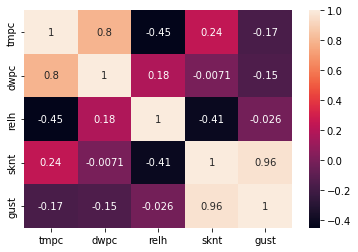

In [7]:
sns.heatmap(data.corr(), annot=True)

The dew point temperature is the temperature to which air must be cooled to become saturated with water vapor, assuming constant air pressure and water content. Therefore, it is understandably correlated with the temperature (the air needed to be cooled), relative humidity (water content) and the wind speed/gust (air pressure). Apart from that, the correlation between the wind speed and the wind gust is quite noticable.

In [8]:
data.describe()

,tmpc,dwpc,relh,sknt,gust
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000
mean,15.811503,12.115772,79.782307,8.919029,30.962594
std,4.235197,3.738005,12.562199,5.348379,6.319510
min,2.000000,-2.000000,29.230000,0.000000,13.000000
25%,13.000000,9.000000,71.450000,5.000000,27.000000
50%,16.000000,12.000000,81.990000,8.000000,31.000000
75%,19.000000,15.000000,88.180000,12.000000,35.000000
max,29.000000,23.000000,100.000000,42.000000,56.000000


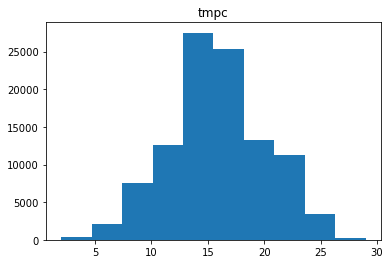

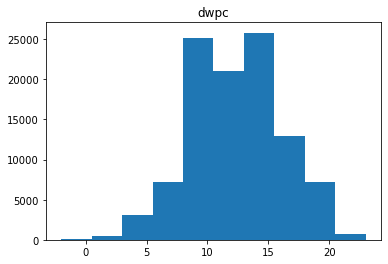

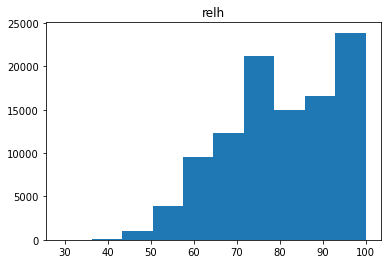

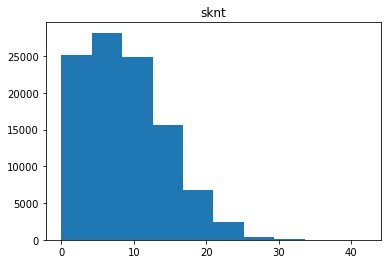

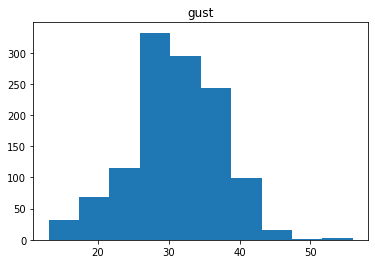

In [9]:
# distributions
for name in data.columns:
    plt.hist(data[name])
    plt.title(name)
    plt.show()

Since they're all numeric values, we care about distributions. Temperature and dew point temperature are approximately normally distributed, while others are skewed.

## Data Preparation

### Imputation

In [10]:
data['gust'].fillna(data['sknt'], inplace=True)

When 'gust' is nan, there's assumingly no significant change in the wind speed. -> it can be filled with the wind speed at the same time.

In [11]:
data.fillna((data.fillna(method='bfill')+data.fillna(method='ffill'))/2, inplace=True)

When other columns are nan, we assume they don't significantly change over a short period. -> they can be filled with the average of the last and the next valid observations.

### Preprocessing

#### Train and test sets

In [12]:
pd.date_range(data.index.min(), data.index.max())

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', length=2191, freq='D')

The data spanned 6 years from 2015 to 2020. 

In [13]:
train = data[:'2020-09']
test = data['2020-10':]

We use the last 3 months to evaluate our model.

## Data Modelling

#### Visualize the Time Series

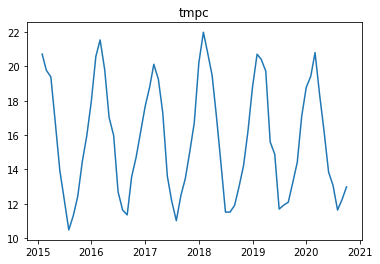

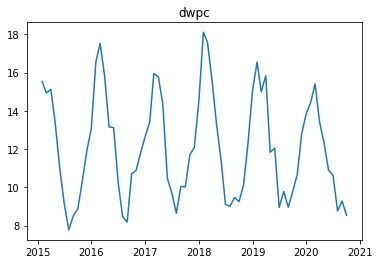

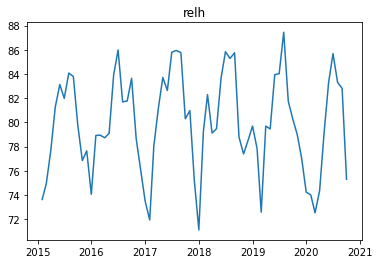

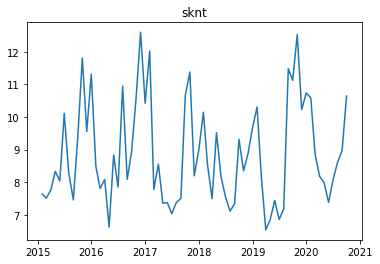

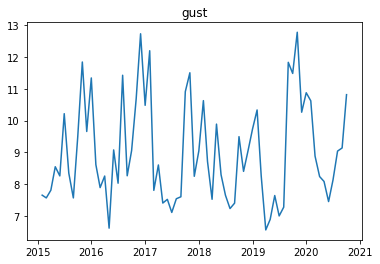

In [14]:
for colunm_name in train.columns:
    plt.plot(train.resample("M")[colunm_name].mean())
    plt.title(colunm_name)
    plt.show()

We can see from the run-sequence plots that the first three (tmpc, dwpc, relh) are approximately stationary, the last two might need some adjustments before fitted into time series models. 

#### Stationarize the Series

In [15]:
## Utility function to perform Dickey-Fuller Test where the null hypothesis is that the series is not stationary
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [16]:
## test against each column
for colunm_name in train.columns:
    print("Please find the result below for %s: "%(colunm_name))
    dftest(train[[colunm_name]])
    print("\n")

Please find the result below for tmpc: 
Test Statistic         -1.004529e+01
p-value                 1.459917e-17
Lags Used               6.400000e+01
Observations Used       9.928600e+04
Critical Value (1%)    -3.430416e+00
Critical Value (5%)    -2.861569e+00
Critical Value (10%)   -2.566785e+00
dtype: float64


Please find the result below for dwpc: 
Test Statistic         -1.467136e+01
p-value                 3.262873e-27
Lags Used               6.700000e+01
Observations Used       9.928300e+04
Critical Value (1%)    -3.430416e+00
Critical Value (5%)    -2.861569e+00
Critical Value (10%)   -2.566785e+00
dtype: float64


Please find the result below for relh: 
Test Statistic            -25.949301
p-value                     0.000000
Lags Used                  62.000000
Observations Used       99288.000000
Critical Value (1%)        -3.430416
Critical Value (5%)        -2.861569
Critical Value (10%)       -2.566785
dtype: float64


Please find the result below for sknt: 
Test Statist

To our surprise, they all passed the test with the p-value small enough (p<0.05) to reject the null hypothesis, i.e., they are all stationary. However, bear in mind that the test won't be able the capture the strong seasonality, but this can be addressed when we fit the models.